In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
torch.manual_seed(1)

In [4]:
def load_data(train_batch_size, test_batch_size):
    trainset = datasets.MNIST('data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
    train_load = torch.utils.data.DataLoader(trainset, batch_size = train_size, shuffle=True)
    testset = datasets.MNIST('data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
    test_load = torch.utils.data.DataLoader(testset ,batch_size = test_size, shuffle=True)
    return (train_load, test_load)

In [5]:
class Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, val):
        val = F.relu(self.fc1(val))
        val = F.relu(self.fc2(val))
        val = self.fc3(val)
        return val

In [6]:
def find_loss(model, loader, loss_fn):
    correct = 0
    total = 0
    costTotal = 0
    costCounter = 0
    with torch.no_grad():
        for batch in loader:
            data, target = batch
            output = model(data.view(-1, 784))
            cost = loss_fn(output, target)
            costTotal += cost
            costCounter += 1
            for i, outputTensor in enumerate(output):
                if torch.argmax(outputTensor) == target[i]:
                    correct += 1
                total += 1
    return costTotal / costCounter, round(correct/total, 3)

In [7]:
def trainFunc(model, num_epochs, train_loader, test_loader, optimizer, loss_fn):
    model.train()
    df = pd.DataFrame()
    train_loss_arr, test_loss_arr, train_acc_arr, test_acc_arr = [], [], [], []
    epoch = 0
    for epoch in range(num_epochs):
        for _, (images, labels) in enumerate(train_loader):  
            images, labels = Variable(images), Variable(labels)     
            optimizer.zero_grad()
            prediction = model(images.view(-1, 784))  # Adjust depending on the input shape
            loss = loss_fn(prediction, labels)
            loss.backward()
            optimizer.step()

        temp_df = pd.DataFrame()
        for name, parameter in model.named_parameters():
            if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                temp_df = pd.concat([temp_df, pd.DataFrame(weights).T], axis = 1)
        df = pd.concat([df, temp_df], axis = 0)
        
        train_loss, train_acc = find_loss(model, train_loader, loss_fn)
        test_loss, test_acc = find_loss(model, test_loader, loss_fn)
        train_loss_arr.append(train_loss)
        test_loss_arr.append(test_loss)
        train_acc_arr.append(train_acc)
        test_acc_arr.append(test_acc)
        epoch = epoch + 1
    return df, train_acc_arr, test_acc_arr, train_loss_arr, test_loss_arr

In [8]:
train_size = 1000
test_size = 1000
train_loader, test_loader = load_data(train_size, test_size)
train_loss_arr = []
test_loss_arr = []
train_acc_arr = []
test_acc_arr = []

In [9]:
max_epochs = 45
all_df = pd.DataFrame()
columns=["x","y","Times"]

loss_fn = nn.CrossEntropyLoss()

for count in range(8):
    print("Time: "+str(count))
    M = Model()
    optimizer = torch.optim.Adam(M.parameters(),lr = 0.0004, weight_decay=1e-4)
    model_name1 = "Times: "+str(count)    
    temp_df, train_acc_arr, test_acc_arr, train_loss_arr, test_loss_arr = trainFunc(M, max_epochs, train_loader, test_loader, optimizer, loss_fn)
    all_df = all_df.append(temp_df)
    

Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7


In [18]:
df = all_df
df = np.array(df)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df)

In [20]:
df = pd.DataFrame(new_data, columns=['x','y'])
repeated_train_acc_arr = np.tile(train_acc_arr, 8)
repeated_train_loss_arr = np.tile(train_loss_arr, 8)
df['Accuracy'] = repeated_train_acc_arr
df['Loss'] = repeated_train_loss_arr
final_df = df.iloc[::3, :]

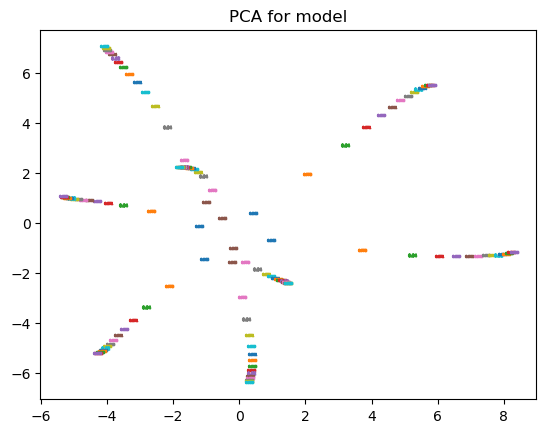

In [21]:
for i in range(120):
    m = list(final_df['Accuracy'])[i]
    plt.scatter(final_df['x'][i*3], final_df['y'][i*3], marker = f'${m}$')
    plt.title("PCA for model")

In [22]:
layer_1 = all_df.iloc[ : , 0:7840]

In [23]:
df = layer_1
df = np.array(df)
pca = PCA(n_components=2)
new_data = pca.fit_transform(df)

In [25]:
df = pd.DataFrame(new_data, columns=['x','y'])
dup_train_acc_arr = np.tile(train_acc_arr, 8)
dup_train_loss_arr = np.tile(train_loss_arr, 8)
df['Accuracy'] = dup_train_acc_arr
df['Loss'] = dup_train_loss_arr
final_df = df.iloc[::3, :]

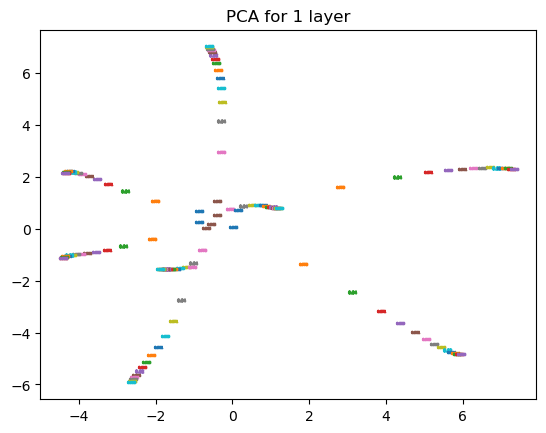

In [26]:
for i in range(120):
    m = list(final_df['Accuracy'])[i]
    plt.scatter(final_df['x'][i*3], final_df['y'][i*3], marker = f'${m}$')
    plt.title("PCA for 1 layer")